In [1]:
#imports
import numpy as np
import gym

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, Visualizer, TrainIntervalLogger, TestLogger

In [2]:
# makes the enviroment
env = gym.make('SpaceInvaders-ram-v4')

nb_actions = env.action_space.n
nb_obs = env.observation_space.shape

print("actions:", nb_actions, "   observations:", nb_obs)

IMG_SHAPE = (100,100) 
WINDOW_LENGTH = 4

input_shape = (WINDOW_LENGTH, IMG_SHAPE[0], IMG_SHAPE[1])


# setup the memory buffer
memory = SequentialMemory(limit=1000,window_length=WINDOW_LENGTH)

# create the policy
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=1.,
                              value_min=.1,
                              value_test=.05,
                              nb_steps=150000) 

actions: 6    observations: (128,)


In [3]:
# file logger callback
logger = FileLogger('training_logs.txt', interval=1) 

In [4]:
# create the neural network model
model = Sequential()
model.add(Flatten(input_shape=(4,) + nb_obs))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))


model.add(Dense(nb_actions))
model.add(Activation('linear'))

In [5]:
# create the agent
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=1000,
               target_model_update=1000, policy=policy, batch_size=32, gamma=0.99)

In [6]:
# compile fit and evaluate teh agent
dqn.compile(Adam(lr=1e-3), metrics=['mae']) 
train_history = dqn.fit(env, nb_steps=1000000,callbacks=[logger], visualize=False, verbose=2)

Training for 1000000 steps ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
    755/1000000: episode: 1, duration: 1.781s, episode steps: 755, steps per second: 424, episode reward: 410.000, mean reward:  0.543 [ 0.000, 200.000], mean action: 2.548 [0.000, 5.000],  loss: --, mae: --, mean_q: --, mean_eps: --
   1426/1000000: episode: 2, duration: 3.721s, episode steps: 671, steps per second: 180, episode reward: 135.000, mean reward:  0.201 [ 0.000, 30.000], mean action: 2.446 [0.000, 5.000],  loss: 204.478364, mae: 89.876626, mean_q: 117.673720, mean_eps: 0.992722
   1973/1000000: episode: 3, duration: 4.065s, episode steps: 547, steps per second: 135, episode reward: 150.000, mean reward:  0.274 [ 0.000, 25.000], mean action: 2.497 [0.000, 5.000],  loss: 118.215152, mae: 101.204109, mean_q: 128.189147, mean_eps: 0.989806
   2840/1000000: episode: 4, duration: 7.461s, episode steps: 867, steps per second: 116, epi

In [15]:
#test the agent
dqn.test(env, nb_episodes=5, visualize=True)
env.close()

Testing for 5 episodes ...
Episode 1: reward: 215.000, steps: 1099
Episode 2: reward: 215.000, steps: 1055
Episode 3: reward: 235.000, steps: 919
Episode 4: reward: 235.000, steps: 923
Episode 5: reward: 235.000, steps: 904


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# get the text file
file = open("training_logs.txt").readlines()
# its a list so just get the first and only text output
text = file[0]

# list of things in the file to remove such that i will be left with lists then loop to delete them
char_del = ['{"loss": ',', "mae": ',', "mean_q": ',', "mean_eps": ',', "episode_reward": ',', "nb_episode_steps": ',', "nb_steps": ',', "episode": ',', "duration": ','}']
textProc = []
for i in range(10):
    text = text.replace(char_del[i],"")
#print(textProc)
text = text.replace("[","")
text = text.replace("NaN","0")

# this turns it from a text thing to a list
textProc = text.split("]")[:-1]
for i in range(len(textProc)):
    textProc[i] = textProc[i].split(",")

# list of the data columns
cols = ["loss", "mae", "mean_q", "mean_eps", "episode_reward", "nb_episode_steps", "nb_steps", "episode", "duration"]

df = pd.DataFrame()
for i in range(len(textProc)):
    df[cols[i]] = textProc[i]

df.to_csv("test.csv")

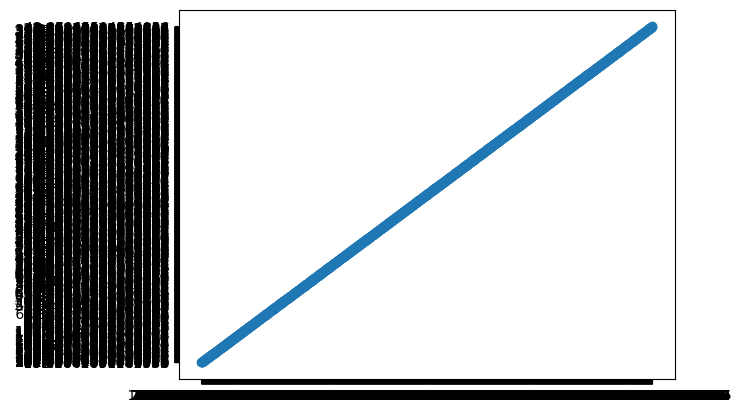

In [16]:
x = df['loss']
y = df['mae']
plt.scatter(x,y)

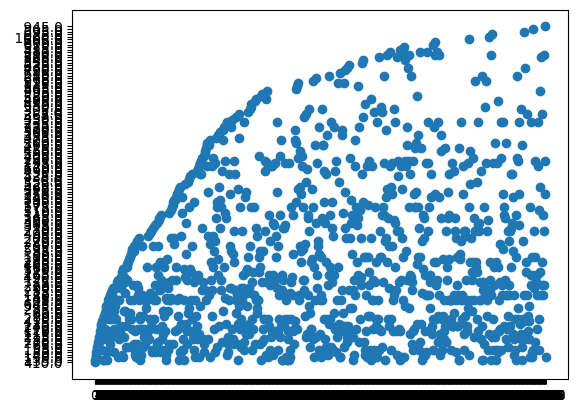

In [11]:
x = df['episode']
y = df['episode_reward']
plt.scatter(x,y)

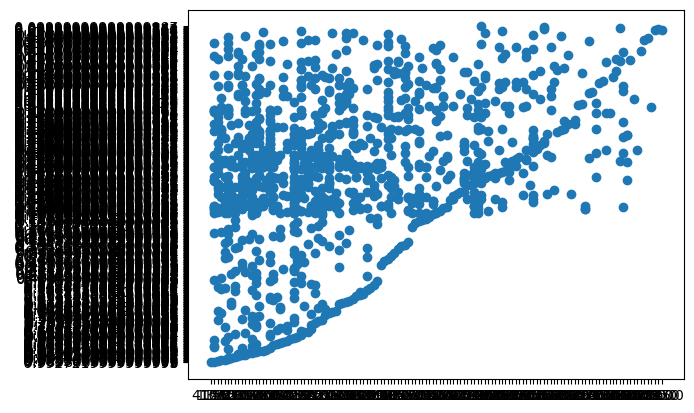

In [12]:
x = df['episode_reward']
y = df['mean_eps']
plt.scatter(x,y)